In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import requests

In [2]:
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession,functions

In [3]:
apps = pd.read_csv('Google-Playstore.csv')

In [4]:
pd.set_option('display.max_columns', 100)

In [6]:
apps.head(5)

App Name  \
0                             HTTrack Website Copier   
1                      World War 2: Offline Strategy   
2                                             WPSApp   
3  OfficeSuite - Office, PDF, Word, Excel, PowerP...   
4                                   Loud Player Free   

                     App Id       Category  Rating  Rating Count  \
0       com.httrack.android  Communication     3.6        2848.0   
1           com.skizze.wwii       Strategy     4.3       17297.0   
2     com.themausoft.wpsapp          Tools     4.2      488639.0   
3    com.mobisystems.office       Business     4.2     1224420.0   
4  com.arthelion.loudplayer  Music & Audio     4.2         665.0   

       Installs  Minimum Installs  Maximum Installs  Free  Price Currency  \
0      100,000+          100000.0            351560  True    0.0      USD   
1    1,000,000+         1000000.0           2161778  True    0.0      USD   
2   50,000,000+        50000000.0          79304739  True    0.0      USD   
3  100,000,000+       100000000.0         163660067  True    0.0      USD   
4       50,000+           50000.0             73463  True    0.0      USD   

   Size Minimum Android  Developer Id           Developer Website  \
0  2.7M      2.3 and up  Xavier Roche     http://www.httrack.com/   
1   86M      5.1 and up  Skizze Games         http://stereo7.com/   
2  5.8M      4.1 and up    TheMauSoft   http://www.themausoft.com   
3   59M      4.4 and up   MobiSystems  http://www.mobisystems.com   
4   29M      5.0 and up   Arthelion92    http://www.arthelion.com   

                               Developer Email      Released  Last Updated  \
0                    roche+android@httrack.com  Aug 12, 2013  May 20, 2017   
1                       Skizze.Games@gmail.com  Jul 19, 2018  Nov 26, 2020   
2                         wpsapp.app@gmail.com   Mar 7, 2016  Oct 21, 2020   
3  support-officesuite-android@mobisystems.com  Dec 22, 2011  Nov 23, 2020   
4                        arthelion92@gmail.com  Sep 24, 2016  Nov 22, 2020   

  Content Rating                                     Privacy Policy  \
0       Everyone     http://android.httrack.com/privacy-policy.html   
1   Everyone 10+     https://www.iubenda.com/privacy-policy/8032781   
2       Everyone    https://sites.google.com/view/wpsapppolicy/main   
3       Everyone  http://www.mobisystems.com/mobile/privacy-poli...   
4       Everyone  http://www.arthelion.com/index.php/fr/android-...   

   Ad Supported  In App Purchases  Editors Choice  
0         False             False           False  
1          True              True           False  
2          True             False           False  
3          True              True           False  
4         False             False           False

In [5]:
len(apps)

1118136

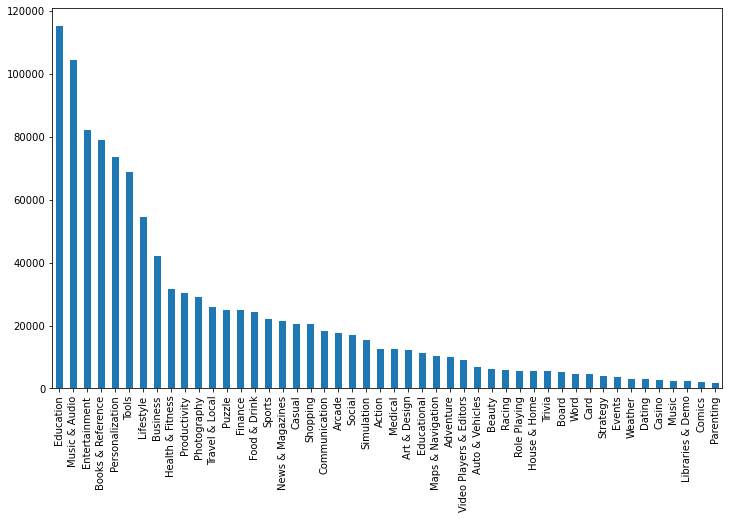

In [6]:
f = plt.figure(figsize=(12,7))
apps['Category'].value_counts().plot(kind='bar')
plt.show()

### Cleaning and filter

In [7]:
games = ['Action','Adventure','Arcade','Board','Card','Casino','Casual','Educational','Music','Puzzle','Racing','Role Playing','Simulation',
        'Sports','Strategy','Trivia','Word']

In [8]:
gameapps = apps[apps['Category'].isin(games)].reset_index(drop=True)

In [9]:
len(gameapps)

175699

In [11]:
gameapps['Released']= pd.to_datetime(gameapps['Released'])

In [12]:
gameapps['Last Updated']= pd.to_datetime(gameapps['Last Updated'])

In [13]:
len(gameapps)

175699

In [14]:
recent = gameapps[gameapps['Last Updated']>'2020-06-30']

In [16]:
recent_free = recent[recent['Price']==0.0].copy()

In [17]:
len(recent_free)

60840

In [14]:
recent_free.drop(columns=['Developer Website','Developer Email','Free','Price','Currency'],inplace=True)

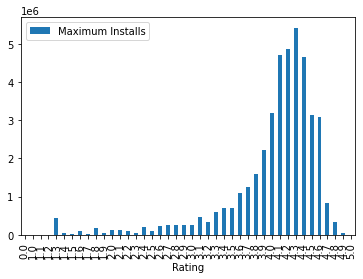

In [17]:
recent_free.groupby(['Rating']).mean()[['Maximum Installs']].plot(kind='bar')

In [15]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    first = regrex_pattern.sub(r'',text)
    second = re.sub('[－’]+', '', first)
    return isEnglish(second)

In [16]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [17]:
recent_free['english']  = recent_free['App Name'].apply(lambda x: deEmojify(x))

In [18]:
recent_free_english = recent_free[recent_free['english']==True].copy()

In [19]:
len(recent_free_english)

56422

### Missing Values

In [23]:
import missingno as msno

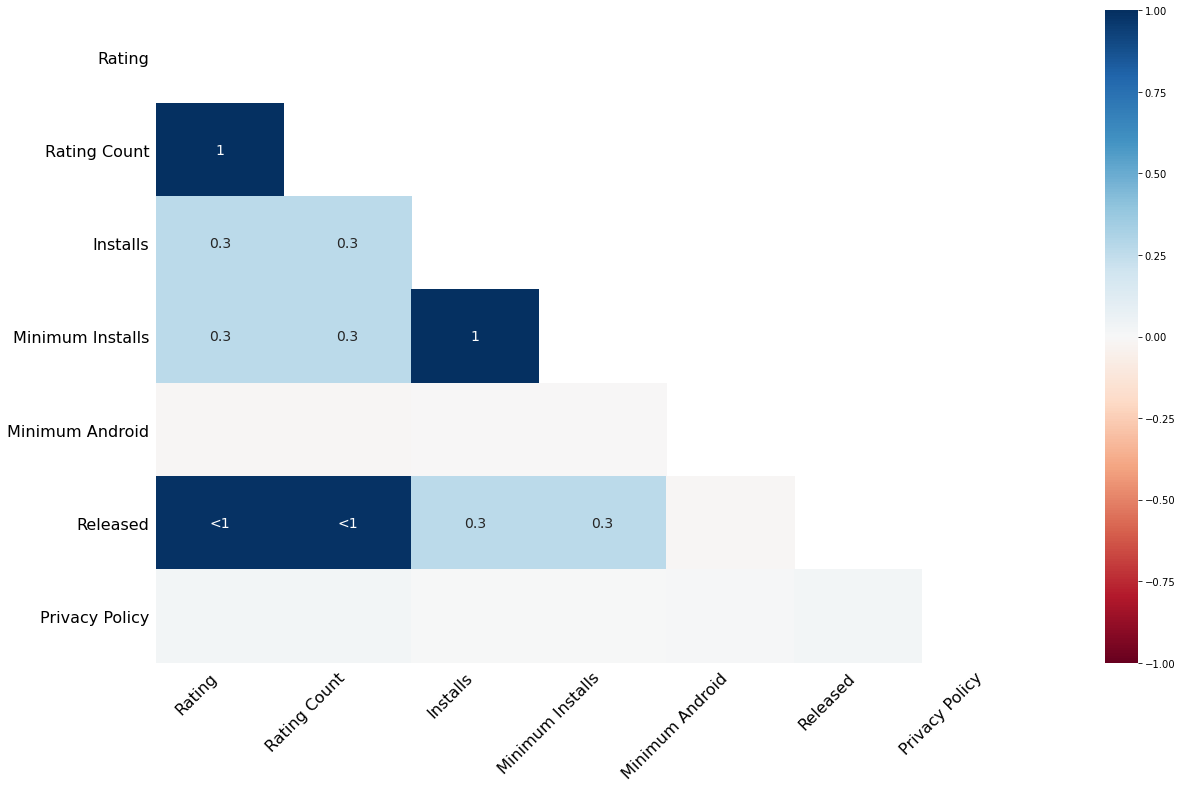

In [24]:
msno.heatmap(recent_free_english)

In [22]:
recent_free_english.isna().sum()

App Name               0
App Id                 0
Category               0
Rating              1668
Rating Count        1668
Installs             126
Minimum Installs     126
Maximum Installs       0
Size                   0
Minimum Android      177
Developer Id           0
Released            1694
Last Updated           0
Content Rating         0
Privacy Policy      3742
Ad Supported           0
In App Purchases       0
Editors Choice         0
english                0
dtype: int64

In [25]:
recent_free_english.dropna(subset=['Rating','Released'],inplace=True)

In [26]:
recent_free_english.isna().sum()

App Name               0
App Id                 0
Category               0
Rating                 0
Rating Count           0
Installs               0
Minimum Installs       0
Maximum Installs       0
Size                   0
Minimum Android      176
Developer Id           0
Released               0
Last Updated           0
Content Rating         0
Privacy Policy      3567
Ad Supported           0
In App Purchases       0
Editors Choice         0
english                0
dtype: int64

In [27]:
recent_free_english.dropna(subset=['Minimum Android'],inplace=True)

In [28]:
recent_free_english['Privacy Policy'] = recent_free_english['Privacy Policy'].fillna(0)

In [29]:
recent_free_english['Privacy Policy'] = recent_free_english['Privacy Policy'].apply(lambda x: 1 if x!=0 else x)

In [30]:
recent_free_english['Privacy Policy'].value_counts()

1    51000
0     3543
Name: Privacy Policy, dtype: int64

## Data Transformation - Feature Engineering

In [31]:
import re
from datetime import date

In [32]:
def remove(x):
    unit = x[-1]
    s = x[:-1]
    num = s.replace(',','')
    if unit == 'M':
        return float(num)
    elif unit == 'k':
        return float(num)/1024
    elif unit == 'G':
        return float(num)*1024
    else:
        return None
recent_free_english['Size'] = recent_free_english['Size'].apply(lambda x: remove(x))

In [33]:
recent_free_english.dropna(subset=['Size'],inplace=True)

In [34]:
recent_free_english['Namelength'] = recent_free_english['App Name'].apply(lambda x: len(x))

In [35]:
recent_free_english['Released days'] = recent_free_english['Released'].apply(lambda x: (pd.to_datetime('2020-12-04')- x).days)

In [36]:
recent_free_english['Last version days'] = recent_free_english['Last Updated'].apply(lambda x: (pd.to_datetime('2020-12-04')- x).days)

In [37]:
len(recent_free_english)

50670

## Outlier Removal

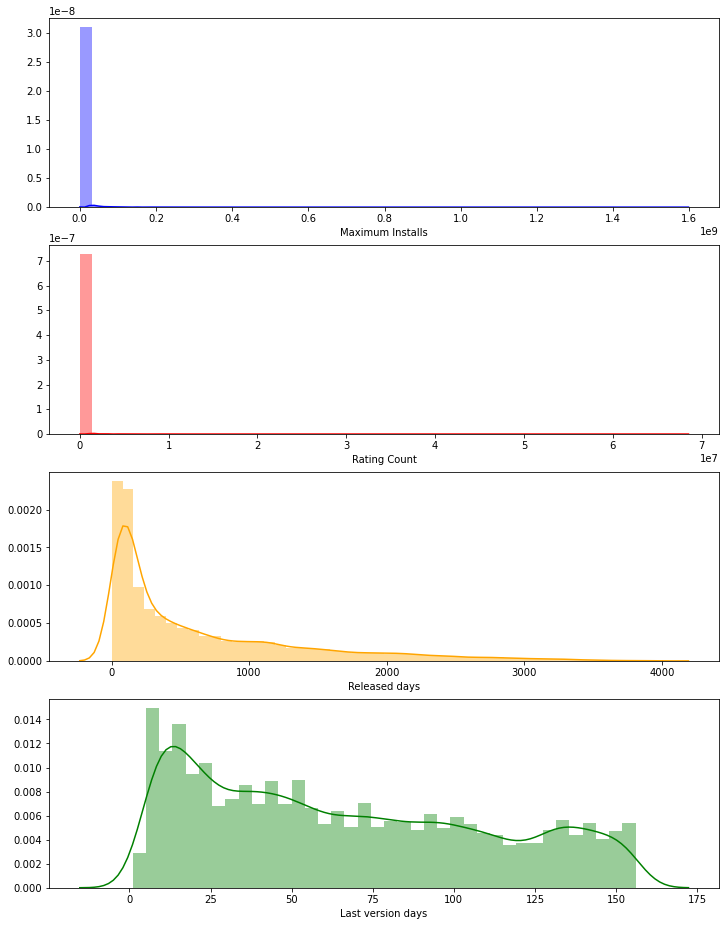

In [165]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(411)
sns.distplot(recent_free_english['Maximum Installs'],color='blue',ax=ax1)
ax2 = f.add_subplot(412)
sns.distplot(recent_free_english['Rating Count'],color='red',ax=ax2)
ax3 = f.add_subplot(413)
sns.distplot(recent_free_english['Released days'],color='orange',ax=ax3)
ax4 = f.add_subplot(414)
sns.distplot(recent_free_english['Last version days'],color='green',ax=ax4)
plt.show()

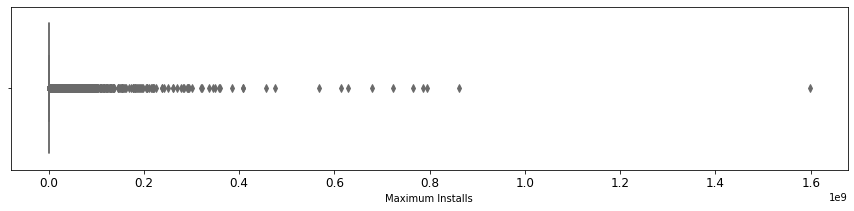

In [161]:
f = plt.figure(figsize=(15,3))
#ax = sns.stripplot(x=recent_free_english['Maximum Installs'],jitter=0.05)
ax = sns.boxplot(y="Maximum Installs", data=recent_free_english,orient="h", palette="Set3")
plt.xticks(fontsize=12)   
plt.show()

In [38]:
Continuous = ['Rating','Rating Count','Maximum Installs','Size','Released days','Last version days','Namelength']

In [39]:
Categorical = ['Category','Minimum Android','Content Rating','Privacy Policy','Ad Supported', 'In App Purchases', 'Editors Choice']

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(recent_free_english[Continuous])

In [42]:
from sklearn.neighbors import LocalOutlierFactor

In [43]:
clf = LocalOutlierFactor(n_neighbors=35)
outliers = clf.fit_predict(scaled)

In [44]:
recent_free_english['Outlier'] = outliers
recent_free_removed = recent_free_english[recent_free_english['Outlier']==1].copy()

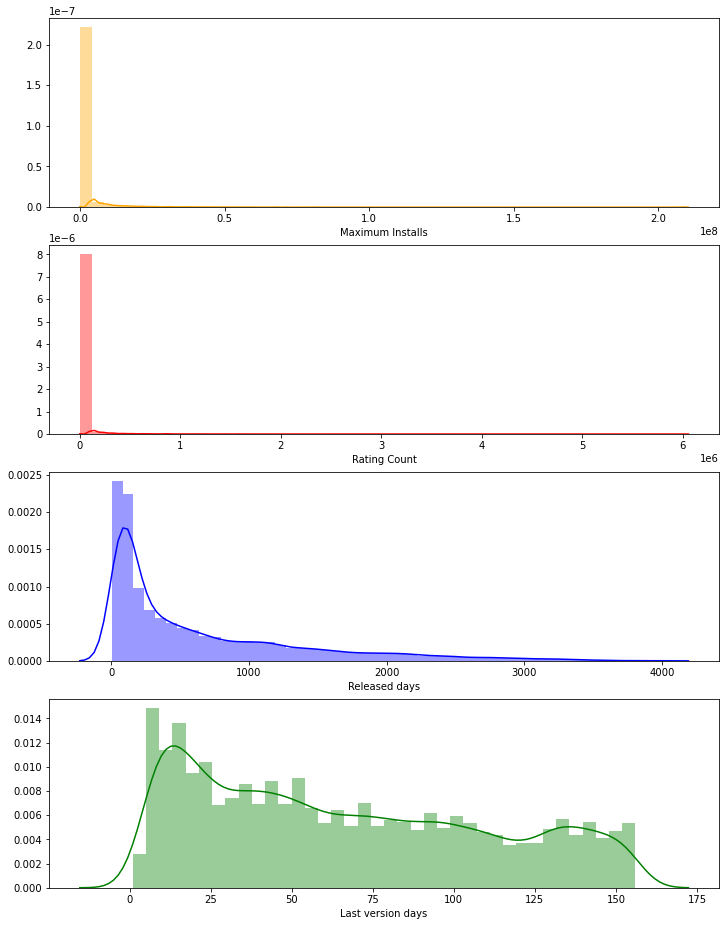

In [168]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(411)
sns.distplot(recent_free_removed['Maximum Installs'],color='orange',ax=ax1)
ax2 = f.add_subplot(412)
sns.distplot(recent_free_removed['Rating Count'],color='red',ax=ax2)
ax3 = f.add_subplot(413)
sns.distplot(recent_free_removed['Released days'],color='blue',ax=ax3)
ax4 = f.add_subplot(414)
sns.distplot(recent_free_removed['Last version days'],color='green',ax=ax4)
plt.show()

In [45]:
len(recent_free_removed)

50307

## Download Images

In [108]:
ids = recent_free_removed['App Id'].tolist()

In [109]:
base = 'https://play.google.com/store/apps/details?id='

In [ ]:
flag=[]
for e,i in enumerate(ids):
    url = base+i
    
    try:
        page = requests.get(url)
        tree = etree.HTML(page.content)
        header = tree.xpath('.//div[@class="xSyT2c"]')[0]
        pic_url = header.xpath('.//img')[0].get("src")
        urllib.request.urlretrieve(pic_url, "images/"+i+".jpg")
        flag.append(1)

    except:
        flag.append(0)
        print(i)

    if e%1000 ==0:
        print(e)

In [121]:
recent_free_removed['image'] = flag

In [ ]:
recent_free_removed = recent_free_removed[recent_free_removed['image']==1].copy()

## App names embeddings

In [47]:
from sentence_transformers import SentenceTransformer

In [48]:
model = SentenceTransformer('stsb-mpnet-base-v2')

#Our sentences we like to encode
appnames = recent_free_removed['App Name'].tolist()

#Sentences are encoded by calling model.encode()
embeddings = model.encode(appnames,show_progress_bar=True)

In [54]:
embeddings.min()

-2.198909

## Merge all columns

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()

In [60]:
scaled_embedding = scaler.fit_transform(embeddings)

In [61]:
pca = PCA(n_components=0.99)
reduced_embedding = pca.fit_transform(scaled_embedding)

In [63]:
reduced_embedding.shape

(54349, 586)

In [75]:
embeddings[198].var()

0.015032879

In [46]:
recent_free_removed['Minimum Android'] =recent_free_removed['Minimum Android'].replace(['1.1 and up','1.6 and up','2.0 and up','2.1 and up','2.2 and up','2.3 and up','2.3.3 and up','3.0 and up','3.1 and up'], '3.2 and up')

In [47]:
recent_free_removed['Minimum Android'] =recent_free_removed['Minimum Android'].replace(['7.0 and up'], '7.1 and up')

In [48]:
recent_free_removed_cats = pd.get_dummies(recent_free_removed[Categorical],drop_first=True).reset_index(drop=True)
recent_free_removed_cats['Ad Supported'] = recent_free_removed_cats['Ad Supported'].astype(int)
recent_free_removed_cats['In App Purchases'] = recent_free_removed_cats['Ad Supported'].astype(int)
recent_free_removed_cats['Editors Choice'] = recent_free_removed_cats['Editors Choice'].astype(int)

In [91]:
# recent_free_removed[['Rating','Rating Count','Size','Released days','Last version days','Namelength']] = scaled_continuous 

In [49]:
base = recent_free_removed[['App Id','App Name','Rating','Rating Count','Size','Released days','Last version days','Namelength','Maximum Installs']].reset_index(drop=True)

In [113]:
embedding_columns= ['embedding'+str(i) for i in range(586)]
name_embeddings = pd.DataFrame(reduced_embedding,columns = embedding_columns)

In [50]:
final= pd.concat([base,recent_free_removed_cats],axis=1)

In [53]:
final

In [54]:
final.head()

App Id                           App Name  \
0                        com.skizze.wwii      World War 2: Offline Strategy   
1             com.sinyee.babybus.village          Little Panda’s Dream Town   
2           com.sinyee.babybus.dentistII            Baby Panda: Dental Care   
3       com.beurer.connect.EMSHomeStudio              Beurer EMS HomeStudio   
4                    soccer.tutor.reader                       Coach Viewer   
...                                  ...                                ...   
43727  com.hmadpuzzlegame.hmadpuzzlegame             Puzzle -Learn and play   
43728                     com.hmad.knife                     Game of Swords   
43729     com.kllyazilim.iddaaskoranaliz                      Score Analyze   
43730                    com.score.iddaa       SCORE - iddaa tahmin, analiz   
43731   com.predictionsfree.tips.betting  Free Betting Predictions and Tips   

       Rating  Rating Count   Size  Released days  Last version days  \
0         4.3       17297.0   86.0            869                  8   
1         4.0       44700.0   90.0            841                 66   
2         4.1       10990.0   87.0            221                 66   
3         2.4          20.0  113.0            612                100   
4         4.4         505.0   16.0           2649                115   
...       ...           ...    ...            ...                ...   
43727     0.0           0.0    4.4            374                 53   
43728     0.0           0.0    7.0            262                151   
43729     4.4         662.0    9.7            605                 23   
43730     4.8         634.0    5.3             92                 62   
43731     4.3           6.0    6.8             79                 54   

       Namelength  Maximum Installs  Privacy Policy  Ad Supported  \
0              29           2161778               1             1   
1              25          29969311               1             1   
2              23          12520805               1             1   
3              21              2406               1             0   
4              12             66814               1             0   
...           ...               ...             ...           ...   
43727          22                 1               1             1   
43728          14                15               1             1   
43729          13             35790               1             1   
43730          28             10160               1             1   
43731          33               371               1             1   

       In App Purchases  Editors Choice  Category_Adventure  Category_Arcade  \
0                     1               0                   0                0   
1                     1               0                   0                0   
2                     1               0                   0                0   
3                     0               0                   0                0   
4                     0               0                   0                0   
...                 ...             ...                 ...              ...   
43727                 1               0                   0                0   
43728                 1               0                   0                0   
43729                 1               0                   0                0   
43730                 1               0                   0                0   
43731                 1               0                   0                0   

       Category_Board  Category_Card  Category_Casino  Category_Casual  \
0                   0              0                0                0   
1                   0              0                0                0   
2                   0              0                0                0   
3                   0              0                0                0   
4                   0              0                0       

In [55]:
final.columns = final.columns.str.replace(' ', '_')

In [56]:
final.drop(columns=['App_Name','In_App_Purchases'],inplace=True)

In [57]:
final.to_csv('apps.csv')

In [93]:
import pandas_profiling
finalapp.profile_report()

## Logistic Regression

### Propensity Score Text

In [102]:
import statsmodels.api as sm

In [100]:
x=finalapp.iloc[:,:9]
y = finalapp['istext']

In [103]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.399890
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.026      
Dependent Variable: istext           AIC:              34993.9367 
Date:               2021-06-21 17:19 BIC:              35072.1093 
No. Observations:   43732            Log-Likelihood:   -17488.    
Df Model:           8                LL-Null:          -17947.    
Df Residuals:       43723            LLR p-value:      7.3306e-193
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Rating            -0.0754   0.0079  -9.5462 0.0000 -0.0908 -0.0599
Rating_Count       0.0000   0.0000   0.8683 0.3852 -0

In [104]:
x  = finalapp.loc[:,:'Category_Word']

In [105]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.377068
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.081     
Dependent Variable:    istext            AIC:               33029.8884
Date:                  2021-06-21 17:19  BIC:               33247.0343
No. Observations:      43732             Log-Likelihood:    -16490.   
Df Model:              24                LL-Null:           -17947.   
Df Residuals:          43707             LLR p-value:       0.0000    
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Rating                -0.0697   0.0081  -8.5676 0.0000 -0.0856 -0.0537
Rat

In [106]:
x = finalapp.loc[:,:'Content_Rating_Teen']

In [107]:
logit_model=sm.Logit(y,x)
result=logit_model.fit(maxiter=50)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.372242
         Iterations 7
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.093     
Dependent Variable:       istext                 AIC:                    32641.8169
Date:                     2021-06-21 17:20       BIC:                    33006.6220
No. Observations:         43732                  Log-Likelihood:         -16279.   
Df Model:                 41                     LL-Null:                -17947.   
Df Residuals:             43690                  LLR p-value:            0.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           7.0000                                                   
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------

### Propensity Score Face

In [108]:
y = finalapp['face']
x=finalapp.iloc[:,:9]

In [226]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.463075
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: -0.025    
Dependent Variable:  face             AIC:              40520.3869
Date:                2021-06-19 16:27 BIC:              40598.5594
No. Observations:    43732            Log-Likelihood:   -20251.   
Df Model:            8                LL-Null:          -19764.   
Df Residuals:        43723            LLR p-value:      1.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Rating            -0.0227   0.0075  -3.0305 0.0024 -0.0374 -0.0080
Rating_Count       0.0000   0.0000   3.6245 0.0003  0

In [227]:
x  = finalapp.loc[:,:'Category_Word']
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.432449
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.043     
Dependent Variable:    face              AIC:               37873.7125
Date:                  2021-06-19 16:27  BIC:               38090.8584
No. Observations:      43732             Log-Likelihood:    -18912.   
Df Model:              24                LL-Null:           -19764.   
Df Residuals:          43707             LLR p-value:       0.0000    
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Rating                -0.0057   0.0082  -0.6938 0.4878 -0.0217  0.0103
Rat

In [109]:
x = finalapp.loc[:,:'Content_Rating_Teen']
logit_model=sm.Logit(y,x)
result=logit_model.fit(maxiter=70)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.413495
         Iterations 7
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.085     
Dependent Variable:       face                   AIC:                    36249.8978
Date:                     2021-06-21 17:26       BIC:                    36614.7029
No. Observations:         43732                  Log-Likelihood:         -18083.   
Df Model:                 41                     LL-Null:                -19764.   
Df Residuals:             43690                  LLR p-value:            0.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           7.0000                                                   
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------